<a href="https://colab.research.google.com/github/gsiraji/omicsPractice/blob/main/genpals_tutorial3_qc_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Copy this notebook!

First please copy this notebook to your own Google drive, you won't be able to run it otherwise! Use **File > Save a Copy in Drive**.


# Install required libraries

In [ ]:
# note: more recent versions of scanpy are causing matplotlib issues wtih google colab!!!
! pip install 'pandas==1.1.5' 'scanpy[leiden]==1.6.1' 'scrublet==0.2.3' 'numba==0.52' -q

## Make a shortcut to the data folder

Before being able to run the rest of this notebook, you must give colab access to the [data directory](https://drive.google.com/drive/folders/1_ZKcxAGHzKR-WM3l3Ia1g7Ikbqt1f2FK?usp=sharing) by:

1. Follow the above link. Right click the `genpals_data` directory and select `Add shortcut to Drive` to make the data accessible from your drive.

2. Mount your drive by opening the left panel on colab, going to the `Files` menu, and selecting `Mount Drive` at the top right (i**con looks like a folder with the Google Drive logo**). 

3. Run the block below 

4. Once you run it and sign in with your Google account, hit the directory refresh button (icon looks like a folder with a refresh symbol on it) on the bar at the left.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## First pass of dimensionality reduction + clustering

Details can be found in the [previous workshop notebook](https://colab.research.google.com/drive/13AlFEAO0qulH1KU9VOSSDnZQQuActt_4?usp=sharing).

In [ ]:
# load required python libraries
import scanpy as sc
import scrublet as scr 
import numpy as np 
import pandas as pd 

# ignore warnings 
import warnings
warnings.filterwarnings('ignore')

data_dir = "/content/drive/MyDrive/genpals_data/Zhou_2020/"
adata = sc.read('{}adata_unprocessed_10k.h5ad'.format(data_dir))

In [ ]:

# make a layer for counts:
adata.layers['counts'] = adata.X

# annotate the group of mitochondrial genes as 'mt'
adata.var['mt'] = adata.var_names.str.startswith('MT-')

# compute the qc metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# normalize the expression matrix
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# make a layer for log normalized data
adata.layers['log'] = adata.X

# identify highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=3000)

# scale the data matrix and run PCA
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, n_comps=50, svd_solver='arpack', use_highly_variable=True)

# run UMAP and clustering
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30, metric='cosine')
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=1)



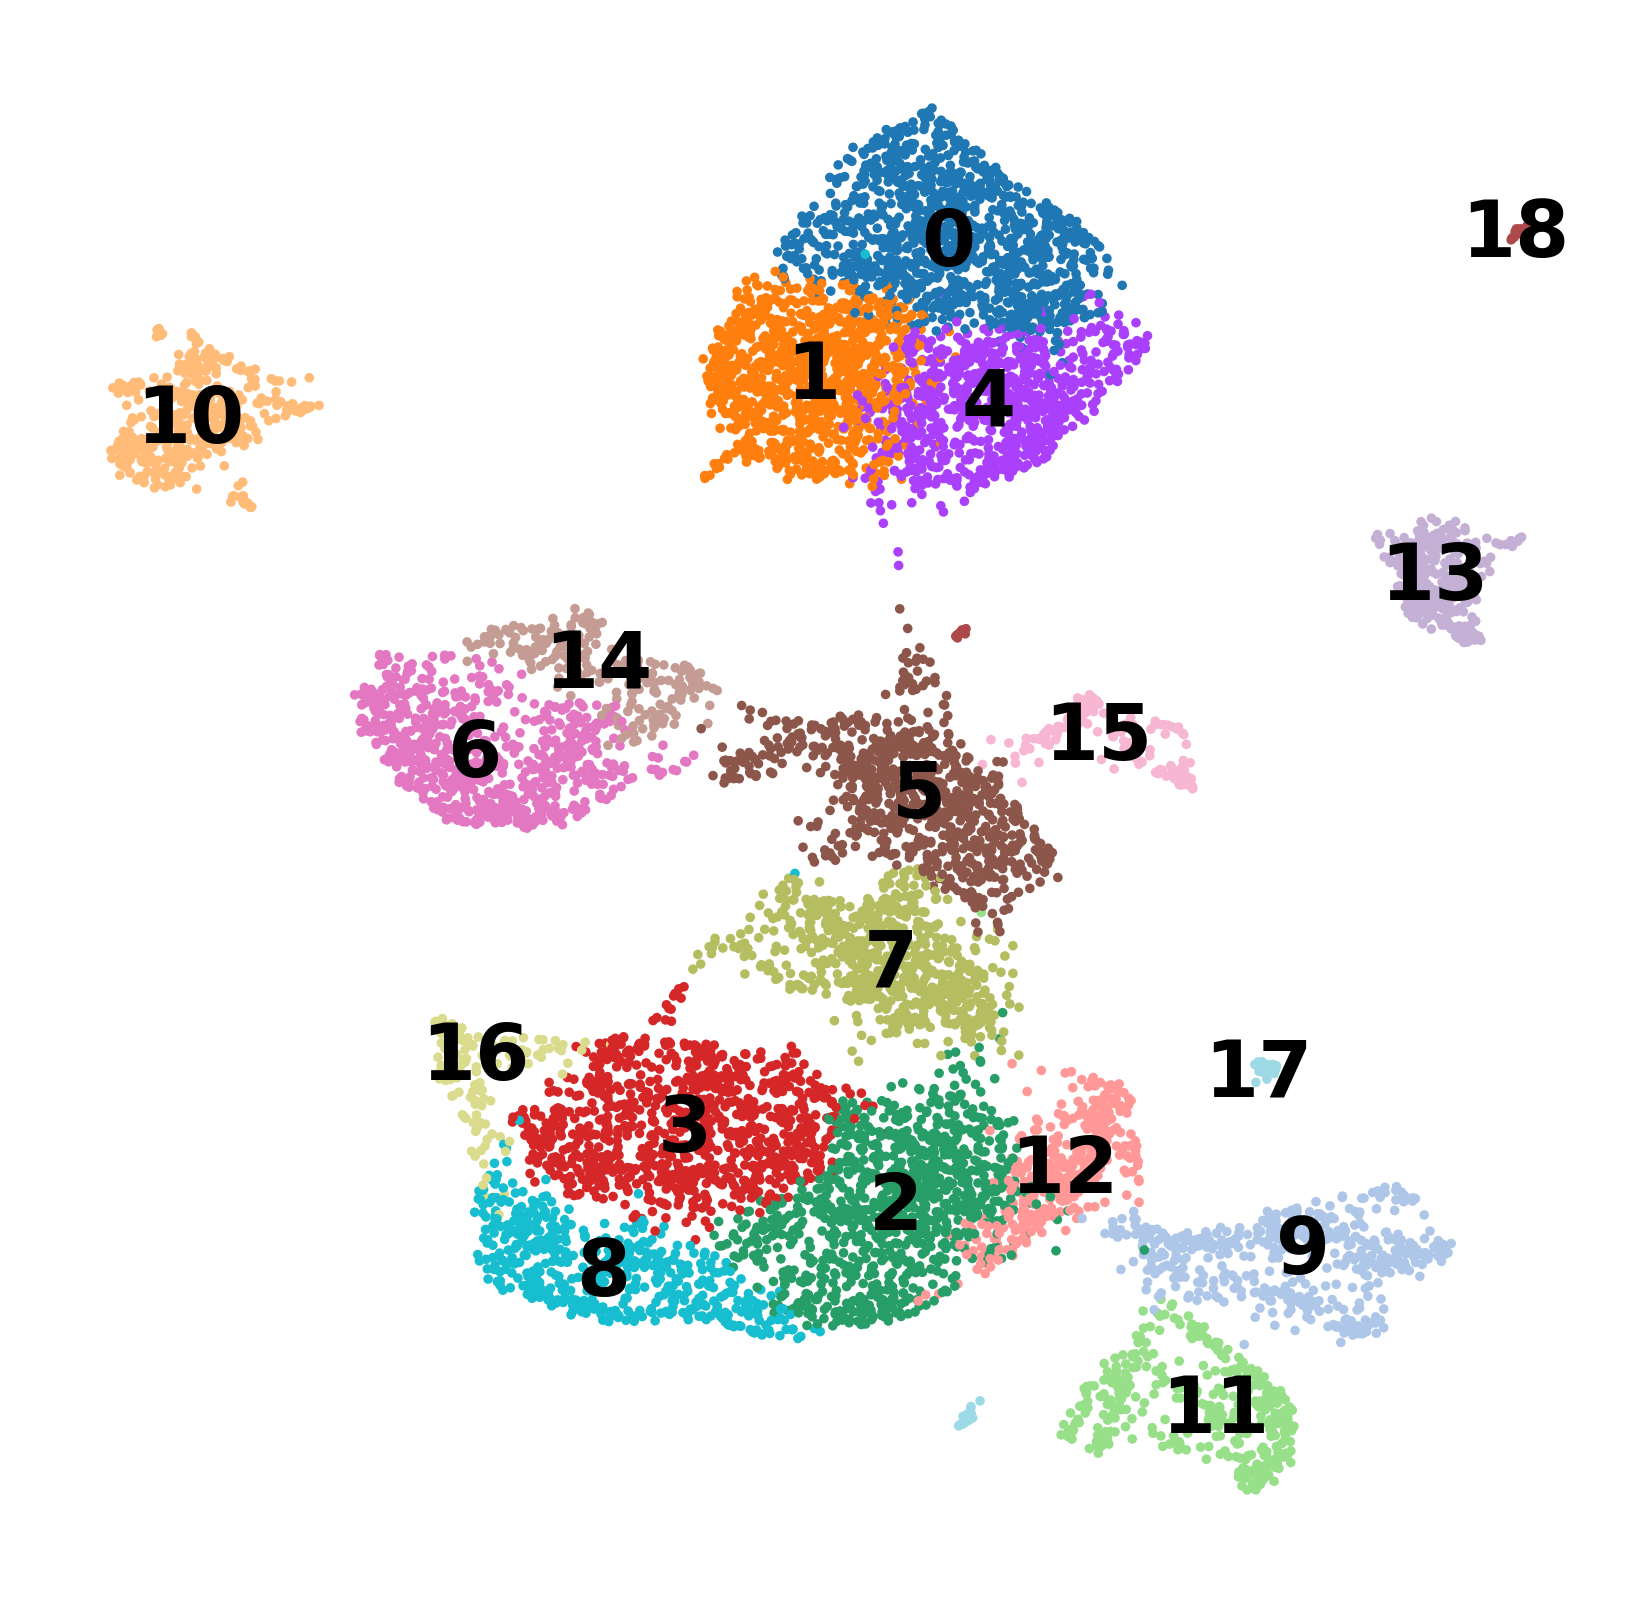

In [ ]:
sc.settings.set_figure_params(dpi=200, dpi_save=200, figsize=(5,5), facecolor='white')
sc.pl.umap(adata, color='leiden', legend_loc='on data', frameon=False, title='')

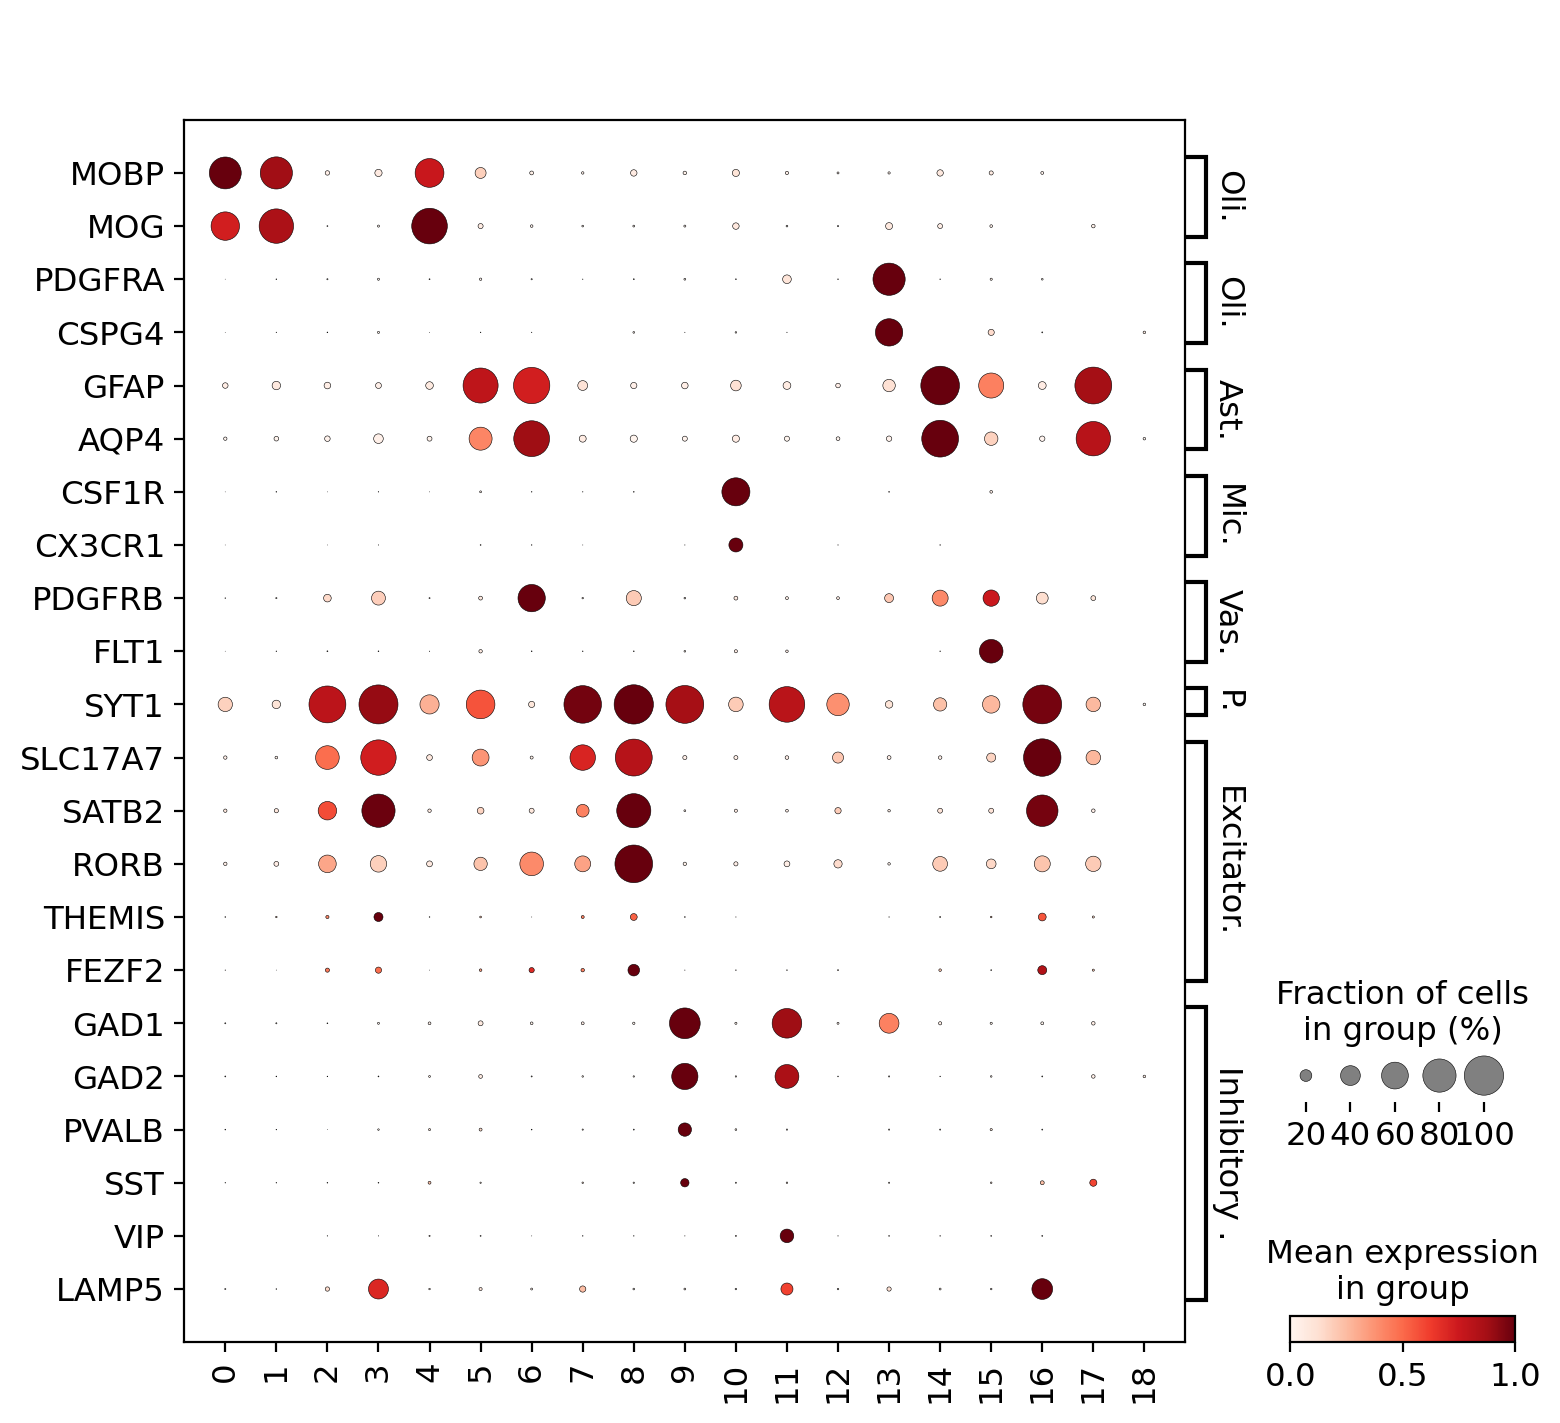

In [ ]:
marker_dict = {
    'Oligodendrocyte': ['MOBP', 'MOG'],
    'Oligodendrocyte Progenitor': ['PDGFRA', 'CSPG4'],
    'Astrocyte': ['GFAP', 'AQP4'],
    'Microglia': ['CSF1R', 'CX3CR1',],
    'Vasculature': ['PDGFRB', 'FLT1'],
    'Pan-neuronal': ['SYT1'],
    'Excitatory Neuron': ['SLC17A7', 'SATB2', 'RORB', 'THEMIS', 'FEZF2'],
    'Inhibitory Neuron': ['GAD1', 'GAD2', 'PVALB', 'SST', 'VIP', 'LAMP5']
}

sc.set_figure_params(dpi=100)
sc.pl.dotplot(
    adata, marker_dict, 'leiden', 
    standard_scale='var', swap_axes=True
)


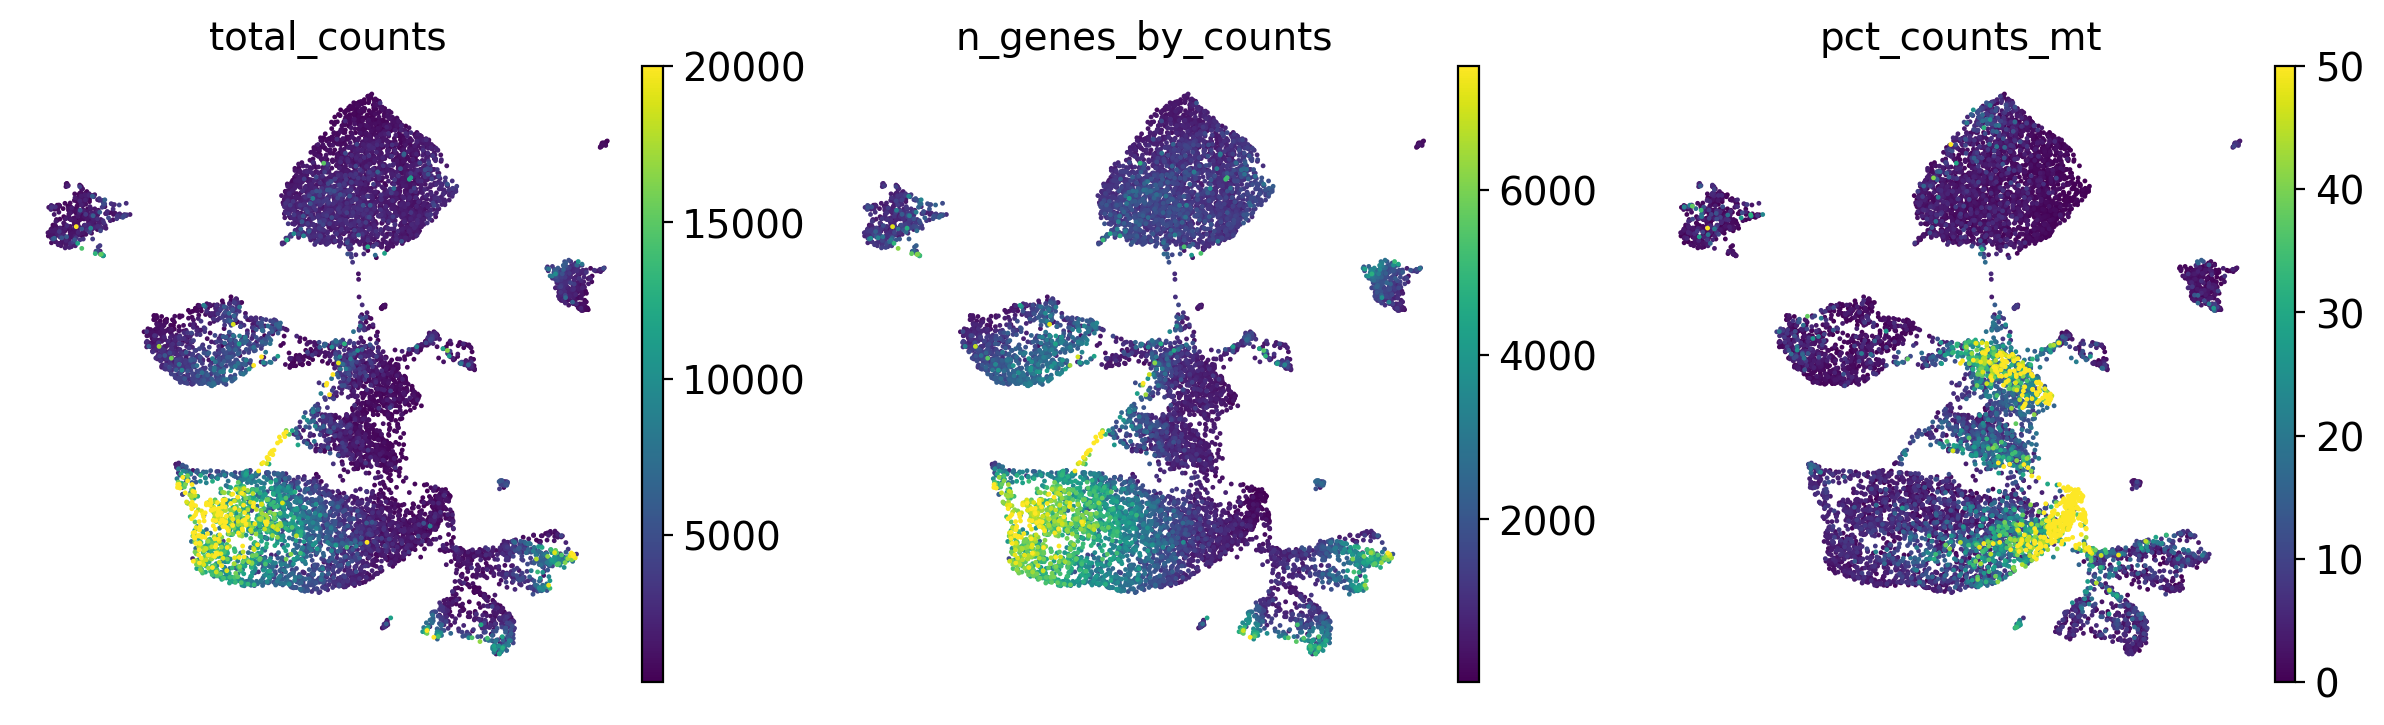

In [ ]:
sc.settings.set_figure_params(dpi=100, dpi_save=1000, figsize=(4,4), facecolor='white')
sc.pl.umap(adata, color=['total_counts', 'n_genes_by_counts', 'pct_counts_mt'], frameon=False, vmax=[20000, 7500, 50])

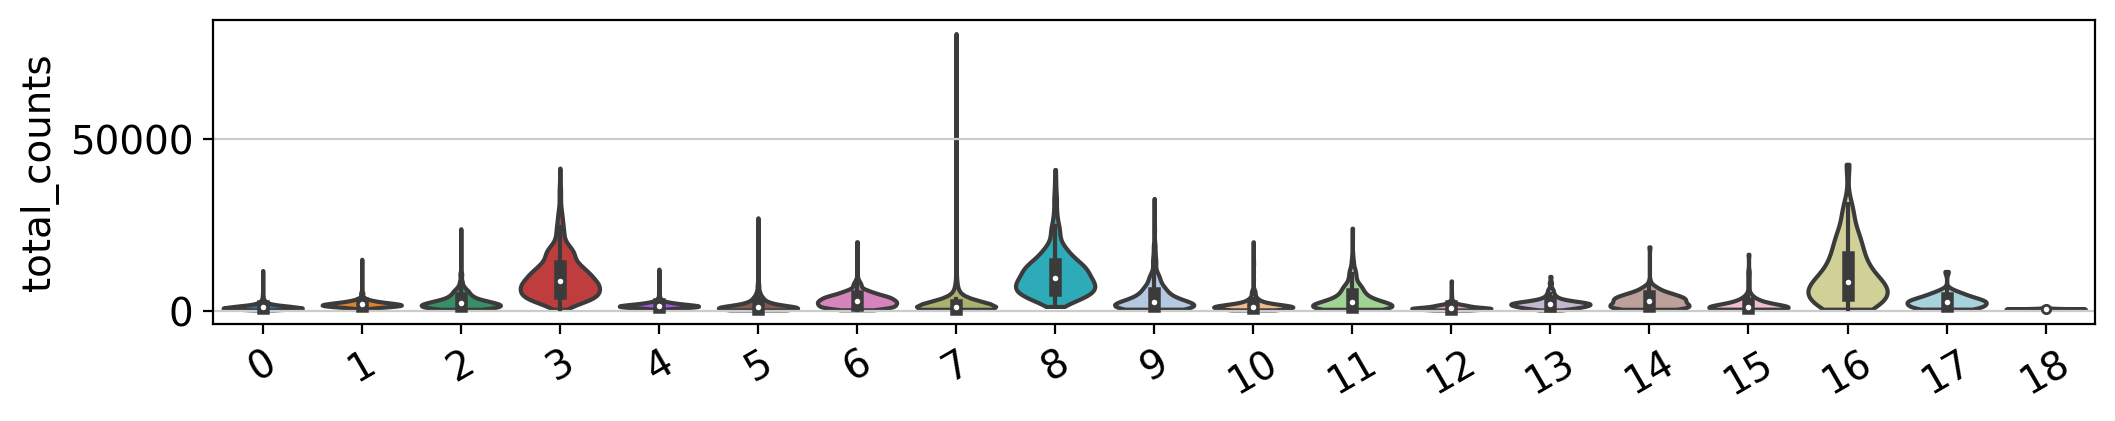

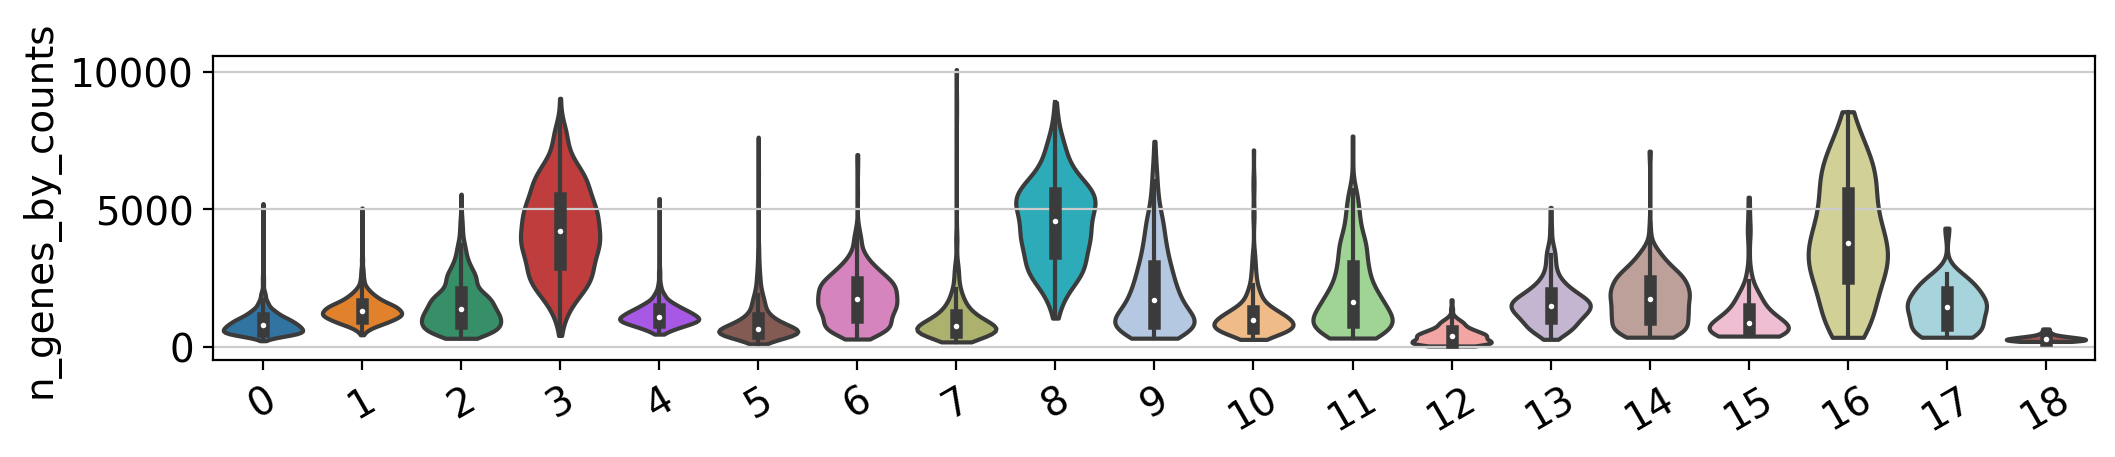

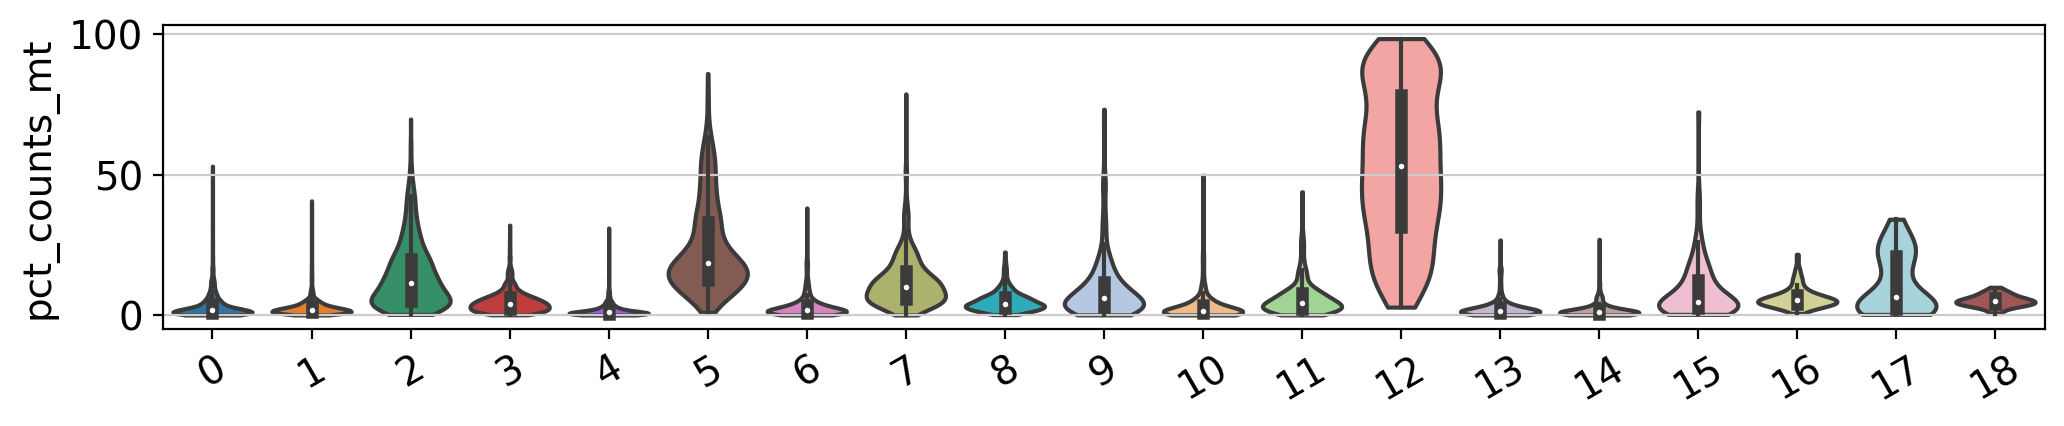

In [ ]:
sc.settings.set_figure_params(dpi=100, figsize=(10,2), facecolor='white')
sc.pl.violin(adata,[ 'total_counts'], inner='box', size=0,  groupby='leiden', multi_panel=False, rotation=30)
sc.pl.violin(adata,[ 'n_genes_by_counts'], inner='box', size=0,  groupby='leiden', multi_panel=False, rotation=30)
sc.pl.violin(adata,[ 'pct_counts_mt'], inner='box', size=0,  groupby='leiden', multi_panel=False, rotation=30)

In [ ]:
# make a copy of the processed dataset 
adata_unfiltered = adata

## Identify doublets

In this section we will run Scrublet to identify doublets in each sample. We have to write a for loop so we can do this separately for each sample, and then we can assemble the results back to the full adata object.

In [ ]:
adata = sc.read('{}adata_unprocessed_10k.h5ad'.format(data_dir))

# make a layer for counts:
adata.layers['counts'] = adata.X

# annotate the group of mitochondrial genes as 'mt'
adata.var['mt'] = adata.var_names.str.startswith('MT-')

# compute the qc metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [ ]:
# make a list of all the different samples
samples = adata.obs.SampleID.unique()
samples

['C8', 'C1', 'C3', 'AD3', 'P7', ..., 'AD7', 'AD8', 'C4', 'AD1', 'AD9']
Length: 32
Categories (32, object): ['C8', 'C1', 'C3', 'AD3', ..., 'AD8', 'C4', 'AD1', 'AD9']

In [ ]:
# list to keep the doublet scores from each sample
df_list = []

# loop over all samples
for i in range(len(samples)):
  print(i)
  # get current sample
  cur_sample = samples[i]

  # subset anndata object for current sample
  cur_adata = adata[adata.obs.SampleID == cur_sample].copy()

  # run scrublet
  scrub = scr.Scrublet(cur_adata.X)
  cur_doublet_scores, cur_predicted_doublets = scrub.scrub_doublets()

  # add results to the obs table in the anndata object
  cur_adata.obs['doublet_score'] = cur_doublet_scores 
  cur_adata.obs['doublet'] = cur_predicted_doublets

  # add to ongoing list
  df_list.append(cur_adata.obs)

# combine results into one table
doublet_df = pd.concat(df_list)
doublet_df

0
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.49
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 4.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 8.5%
Elapsed time: 1.3 seconds
1
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.34
Detected doublet rate = 0.8%
Estimated detectable doublet fraction = 14.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 5.6%
Elapsed time: 0.3 seconds
2
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.40
Detected doublet rate = 1.8%
Estimated detectable doublet fraction = 25.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.8%
Elapsed time: 0.7 seconds
3
Preprocessing...
Simulating

Age Sex SampleID DonorID  Batch  Original_cluster  \
barcode                                                                        
TCAGCTCTCTGGTATG-1_21   89.736   M       C8      C8      2               NaN   
CCTACACCAAACGCGA-1_21   89.736   M       C8      C8      2               NaN   
ACGCAGCGTATCTGCA-1_21   89.736   M       C8      C8      2               NaN   
ATGTGTGGTATAAACG-1_21   89.736   M       C8      C8      2               NaN   
GCGCAACAGGCATGTG-1_21   89.736   M       C8      C8      2               NaN   
...                        ...  ..      ...     ...    ...               ...   
CTTGGCTTCTGCTTGC-1_11  101.262   M      AD9     AD9      2               NaN   
CGACCTTAGCCGGTAA-1_11  101.262   M      AD9     AD9      2               NaN   
AAGCCGCGTACCATCA-1_11  101.262   M      AD9     AD9      2               NaN   
CGCTGGATCCCACTTG-1_11  101.262   M      AD9     AD9      2               NaN   
GTAGGCCTCAGCACAT-1_11  101.262   M      AD9     AD9      2               NaN   

                      Dataset Region  cerad  braak Condition  \
barcode                                                        
TCAGCTCTCTGGTATG-1_21    Zhou    PFC      4      3   Control   
CCTACACCAAACGCGA-1_21    Zhou    PFC      4      3   Control   
ACGCAGCGTATCTGCA-1_21    Zhou    PFC      4      3   Control   
ATGTGTGGTATAAACG-1_21    Zhou    PFC      4      3   Control   
GCGCAACAGGCATGTG-1_21    Zhou    PFC      4      3   Control   
...                       ...    ...    ...    ...       ...   
CTTGGCTTCTGCTTGC-1_11    Zhou    PFC      1      5        AD   
CGACCTTAGCCGGTAA-1_11    Zhou    PFC      1      5        AD   
AAGCCGCGTACCATCA-1_11    Zhou    PFC      1      5        AD   
CGCTGGATCCCACTTG-1_11    Zhou    PFC      1      5        AD   
GTAGGCCTCAGCACAT-1_11    Zhou    PFC      1      5        AD   

                       n_genes_by_counts  total_counts  total_counts_mt  \
barcode                                                                   
TCAGCTCTCTGGTATG-1_21                823        1036.0              4.0   
CCTACACCAAACGCGA-1_21                803        1097.0              2.0   
ACGCAGCGTATCTGCA-1_21                889        1217.0              6.0   
ATGTGTGGTATAAACG-1_21               1119        1479.0             24.0   
GCGCAACAGGCATGTG-1_21               1784        2895.0             78.0   
...                                  ...           ...              ...   
CTTGGCTTCTGCTTGC-1_11               1081        1683.0             62.0   
CGACCTTAGCCGGTAA-1_11               3239        7004.0           1084.0   
AAGCCGCGTACCATCA-1_11                 51         586.0            546.0   
CGCTGGATCCCACTTG-1_11                182         913.0            716.0   
GTAGGCCTCAGCACAT-1_11                674         824.0              6.0   

                       pct_counts_mt  doublet_score  doublet  
barcode                                                       
TCAGCTCTCTGGTATG-1_21       0.386100       0.142857    False  
CCTACACCAAACGCGA-1_21       0.182315       0.158879    False  
ACGCAGCGTATCTGCA-1_21       0.493016       0.116981    False  
ATGTGTGGTATAAACG-1_21       1.622718       0.106383    False  
GCGCAACAGGCATGTG-1_21       2.694301       0.068120    False  
...                              ...            ...      ...  
CTTGGCTTCTGCTTGC-1_11       3.683898       0.093525    False  
CGACCTTAGCCGGTAA-1_11      15.476871       0.142857    False  
AAGCCGCGTACCATCA-1_11      93.174065       0.043478    False  
CGCTGGATCCCACTTG-1_11      78.422783       0.052632    False  
GTAGGCCTCAGCACAT-1_11       0.728155       0.239437    False  

[10000 rows x 17 columns]

In [ ]:
# merge the table 
temp = adata.obs.merge(
    doublet_df,
    how='left',
    left_index=True, right_index=True
)

# transfer the doublet info back to the adata object
adata.obs['doublet_score'] = temp.doublet_score 
adata.obs['doublet'] = temp.doublet.astype('category')


In [ ]:
# add the doublet scores to the adata we already processed:
temp = adata_unfiltered.obs.merge(
    doublet_df,
    how='left',
    left_index=True, right_index=True
)

# transfer the doublet info back to the adata object
adata_unfiltered.obs['doublet_score'] = temp.doublet_score 
adata_unfiltered.obs['doublet'] = temp.doublet.astype('category')


In [ ]:
# how many predicted doublets:
adata_unfiltered.obs.doublet.value_counts()

False    9783
True      217
Name: doublet, dtype: int64

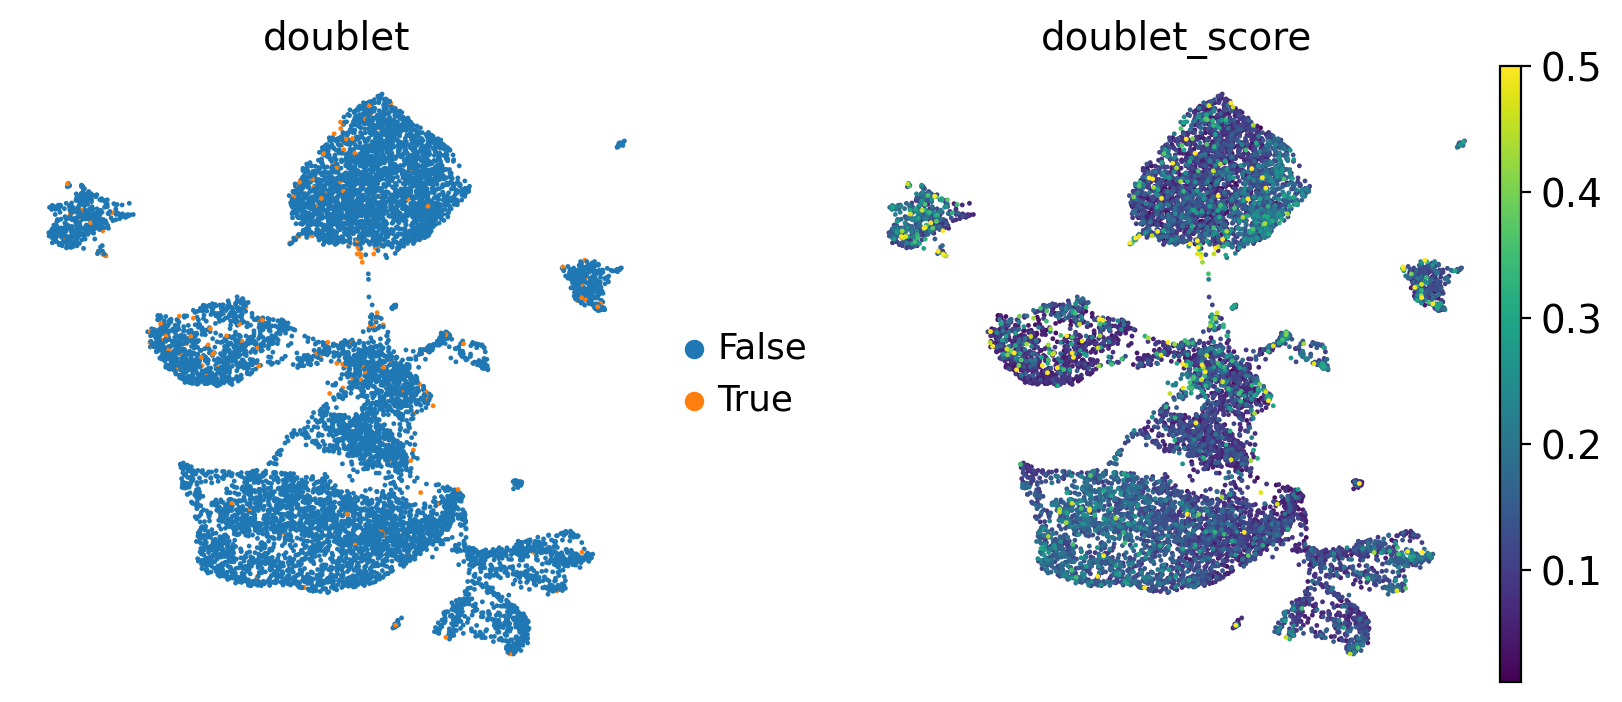

In [ ]:
sc.settings.set_figure_params(dpi=100, dpi_save=1000, figsize=(4,4), facecolor='white')
sc.pl.umap(adata_unfiltered, color=['doublet', 'doublet_score'], frameon=False, vmax=0.5)

In [ ]:
# make a copy of this adata object:
adata_doublet = adata.copy() 

## Filtering based on UMI / gene counts per cell

Scanpy makes it very easy to filter out anomalous cells that either have too many or two few UMIs or genes expressed. 

High UMI counts can indicate potential doublets, as the individual cell barcodes have a higher number of reads than would be expected from any given actual single cell.

On the other hand, low UMI counts are low quality and might be from barcodes that never actually captured a cell, and only contained extracellular genetic material.

Above, we used the `scanpy.pp.calculate_qc_metrics()` function to determine how many UMIs came from each cell as well as how many genes are expressed in each cell.

In [ ]:
adata.obs[['n_genes_by_counts', 'total_counts', 'pct_counts_mt']]

n_genes_by_counts  total_counts  pct_counts_mt
barcode                                                              
TCAGCTCTCTGGTATG-1_21                823        1036.0       0.386100
AAGACCTAGAGGACGG-1_12               1094        1571.0       4.073838
TCCCGATTCCGCATAA-1_16               3231        6113.0       9.618845
CAGATCAGTAGTACCT-1_7                 825        1196.0       9.113712
CCTACACCAAACGCGA-1_21                803        1097.0       0.182315
...                                  ...           ...            ...
GATCTAGCAATGGACG-1_2                 413         519.0       4.431600
CGAGAAGCATCCTTGC-1_32               1377        2292.0       7.024433
AGTTGGTAGAGCAATT-1_20               2377        3855.0       2.308690
GTGCAGCAGGCTAGAC-1_23                725         931.0       5.907626
TACGGATTCTAGAGTC-1_13               1554        2712.0       1.069322

[10000 rows x 3 columns]

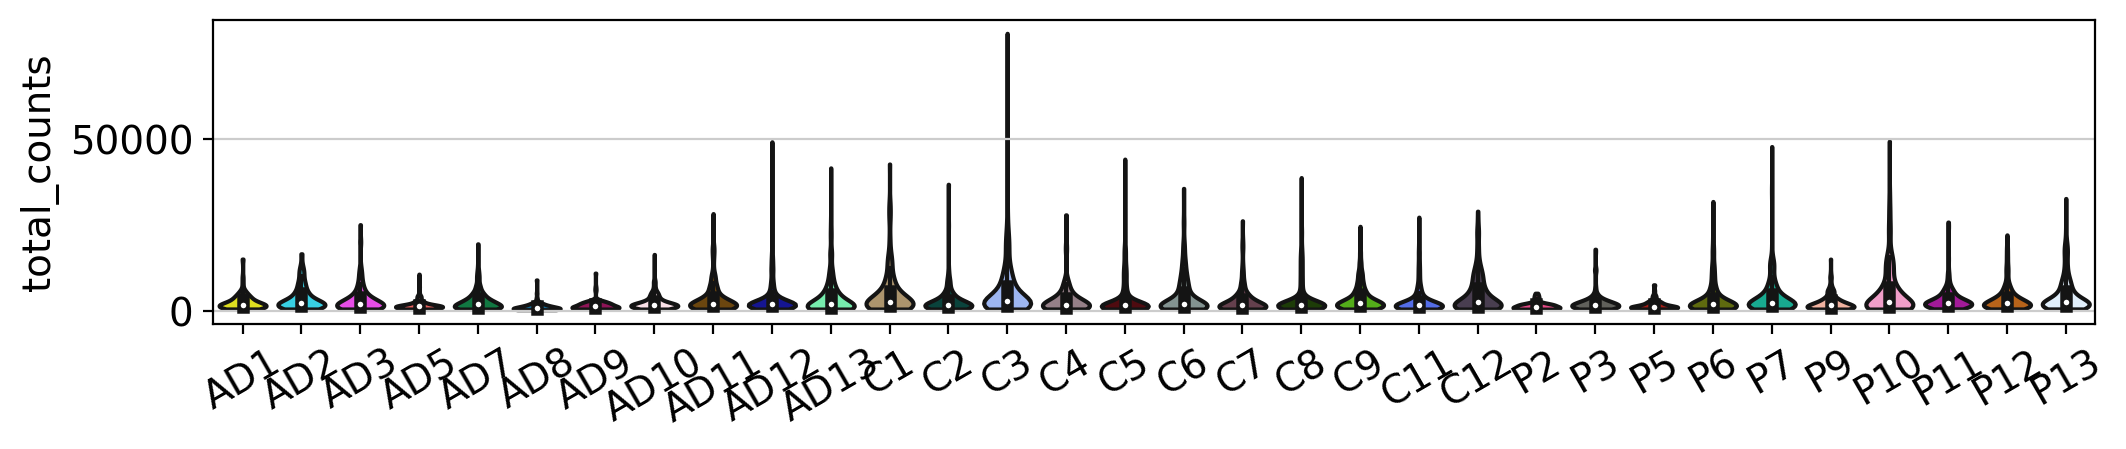

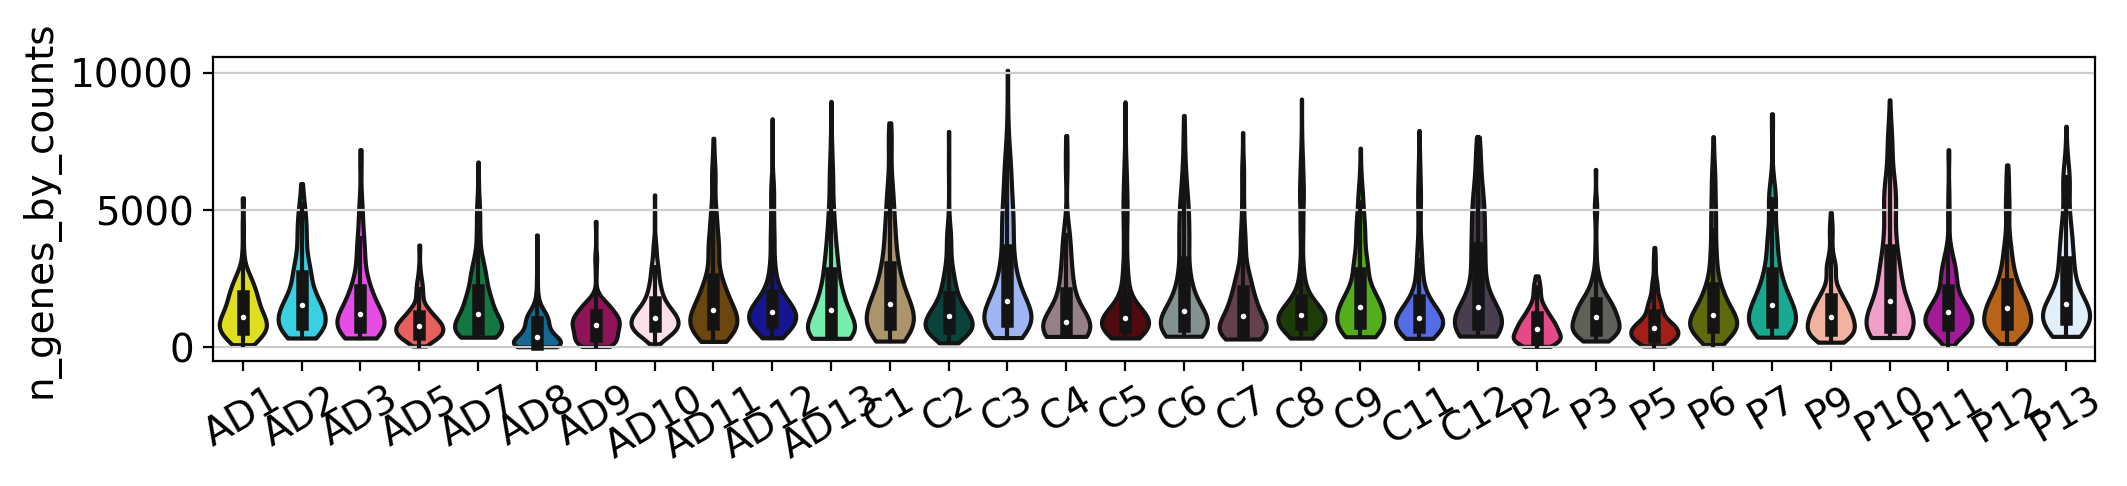

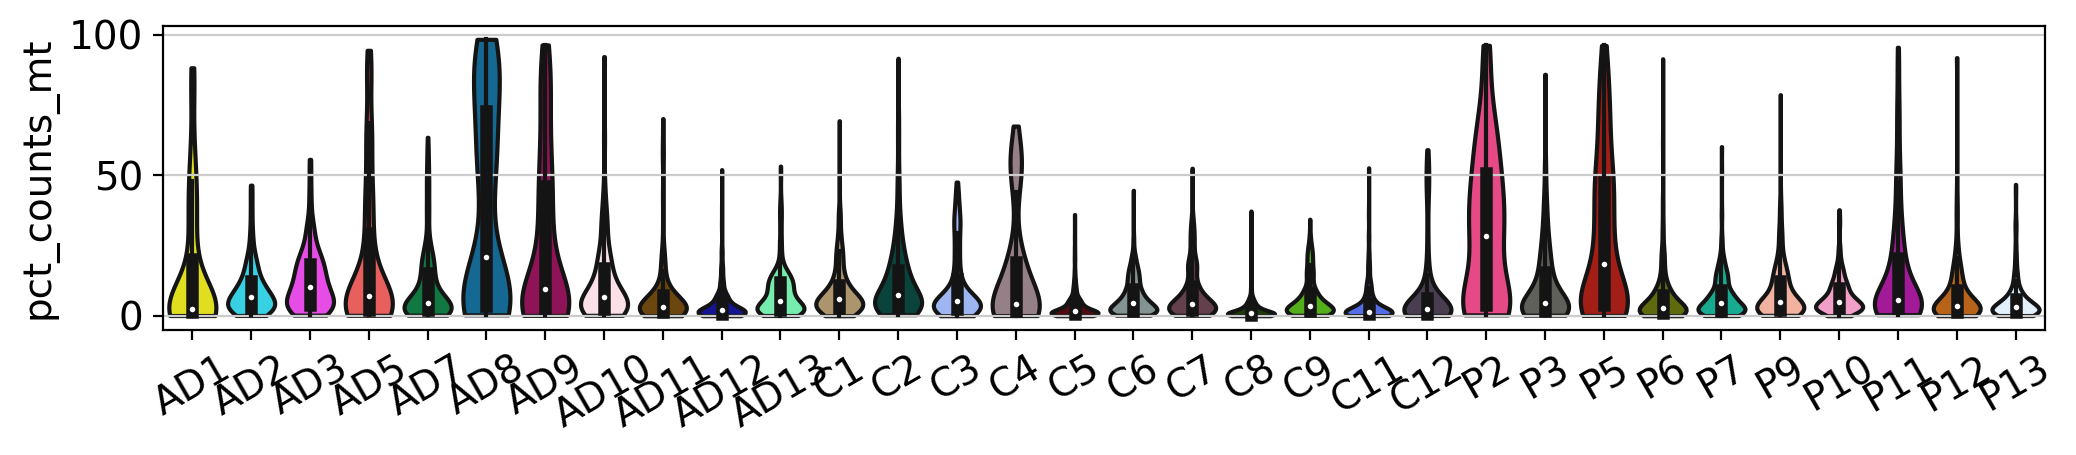

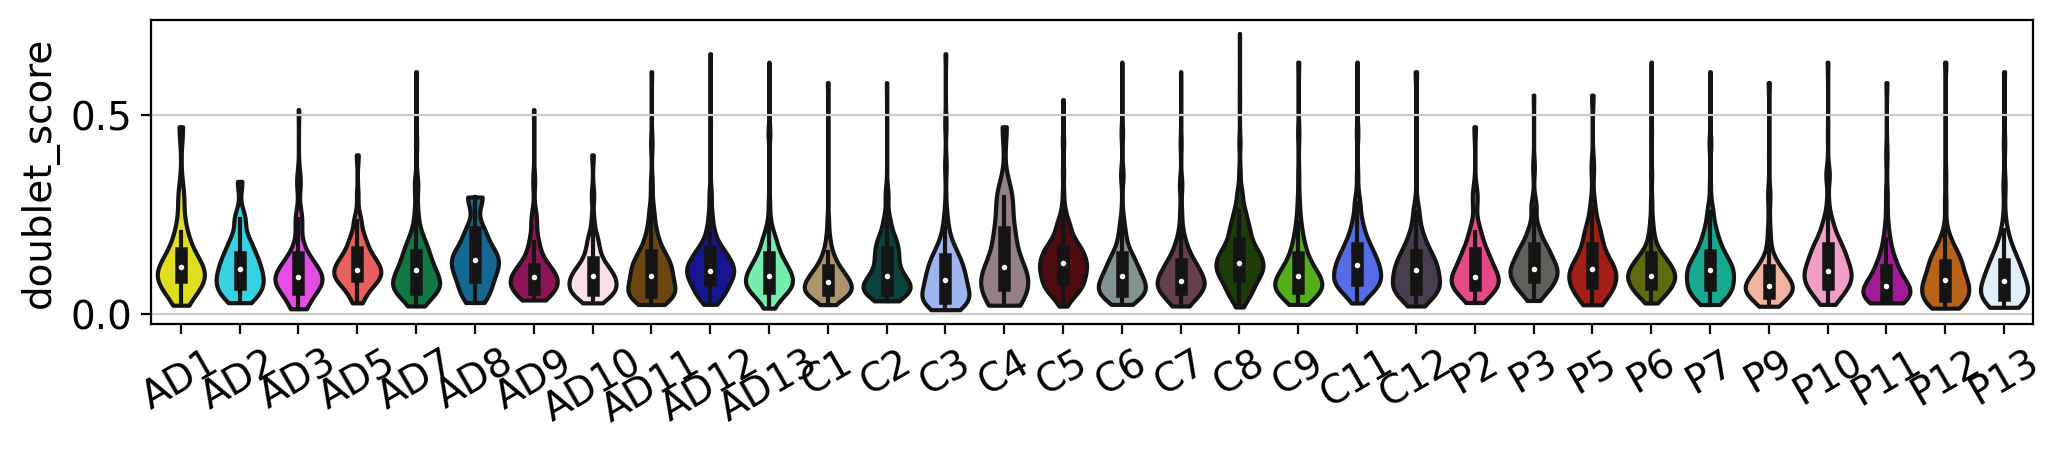

In [ ]:
sc.settings.set_figure_params(dpi=100, figsize=(10,2.), facecolor='white')
sc.pl.violin(adata,[ 'total_counts'], inner='box', size=0,  groupby='SampleID', multi_panel=False, rotation=30)
sc.pl.violin(adata,[ 'n_genes_by_counts'], inner='box', size=0,  groupby='SampleID', multi_panel=False, rotation=30)
sc.pl.violin(adata,[ 'pct_counts_mt'], inner='box', size=0,  groupby='SampleID', multi_panel=False, rotation=30)
sc.pl.violin(adata,[ 'doublet_score'], inner='box', size=0,  groupby='SampleID', multi_panel=False, rotation=30)

## Filtering strategy 1:

We can filter cells based on thresholds determined within each sample. The following blocks of code run a for loop over each sample to identify cells that are outliers in each sample. The thresholds can be modified but we have set them at 0.95, meaning that only the top 5% of cells will be removed in each sample for each of the specified metrics. Here we will filter based on the number of UMIs, the percentage of mitochondrial reads, and the doublet score.

In [ ]:
# start with this adata object: 
adata = adata_doublet.copy()

In [ ]:

# filtering in each sample based on percentiles. 0.95 means we remove the top 5%
mt_quantile = 0.95
umi_quantile = 0.95
doublet_quantile = 0.95

samples = adata.obs.SampleID.unique()
good_barcodes = []
for cur_sample in samples:
    
    # get just this sample
    cur_adata = adata[adata.obs.SampleID == cur_sample]
    orig_cells = cur_adata.shape[0]
    
    # compute cutoffs for each sample
    mt_cutoff = cur_adata.obs.pct_counts_mt.quantile(mt_quantile)
    umi_cutoff = cur_adata.obs.total_counts.quantile(umi_quantile)
    doublet_cutoff = cur_adata.obs.doublet_score.quantile(doublet_quantile)
    
    # subset the data based on thresholds
    cur_adata = cur_adata[(cur_adata.obs.pct_counts_mt < mt_cutoff) & (cur_adata.obs.total_counts < umi_cutoff) & (cur_adata.obs.doublet_score < doublet_cutoff)]
    new_cells = cur_adata.shape[0]
    
    keep_cells = cur_adata.obs.index.to_list() 
    good_barcodes = good_barcodes + keep_cells
    print(cur_sample, 'removed ', orig_cells-new_cells, ', kept ', new_cells)

    

C8 removed  112 , kept  673
C1 removed  36 , kept  216
C3 removed  70 , kept  386
AD3 removed  32 , kept  122
P7 removed  57 , kept  294
C5 removed  149 , kept  619
AD10 removed  40 , kept  231
AD5 removed  42 , kept  186
C11 removed  62 , kept  314
AD13 removed  53 , kept  321
P13 removed  42 , kept  249
P5 removed  36 , kept  164
P12 removed  72 , kept  354
AD12 removed  78 , kept  428
AD11 removed  56 , kept  269
C6 removed  68 , kept  353
C9 removed  57 , kept  305
P2 removed  20 , kept  95
C2 removed  39 , kept  194
P10 removed  70 , kept  293
P3 removed  33 , kept  170
P6 removed  67 , kept  363
P11 removed  38 , kept  212
C7 removed  46 , kept  266
P9 removed  45 , kept  236
C12 removed  48 , kept  261
AD2 removed  31 , kept  129
AD7 removed  54 , kept  302
AD8 removed  25 , kept  89
C4 removed  27 , kept  66
AD1 removed  19 , kept  71
AD9 removed  27 , kept  118


In [ ]:
# subset the full data by the good barcodes
adata = adata[adata.obs.index.isin(good_barcodes)].copy()
adata.shape

(8349, 33694)

## Filtering strategy 2:

We can filter cells based on thresholds applied to the entire dataset. Often in practice we use a combination of these filtering strategies.

In [ ]:
# set cutoffs for the whole dataset rather than per each sample
adata = adata[adata.obs.n_genes_by_counts >= 250].copy()
adata = adata[adata.obs.pct_counts_mt <= 10].copy()
adata = adata[adata.obs.doublet_score <= 0.2].copy()

adata.shape

(6391, 33694)

### Process the dataset after we applied our filters

In [ ]:
# process data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# make a layer for log normalized data
adata.layers['log'] = adata.X


sc.pp.highly_variable_genes(adata, n_top_genes=3000)
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, n_comps=50, svd_solver='arpack', use_highly_variable=True)


In [ ]:
# run clustering
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30, metric='cosine')
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.75)


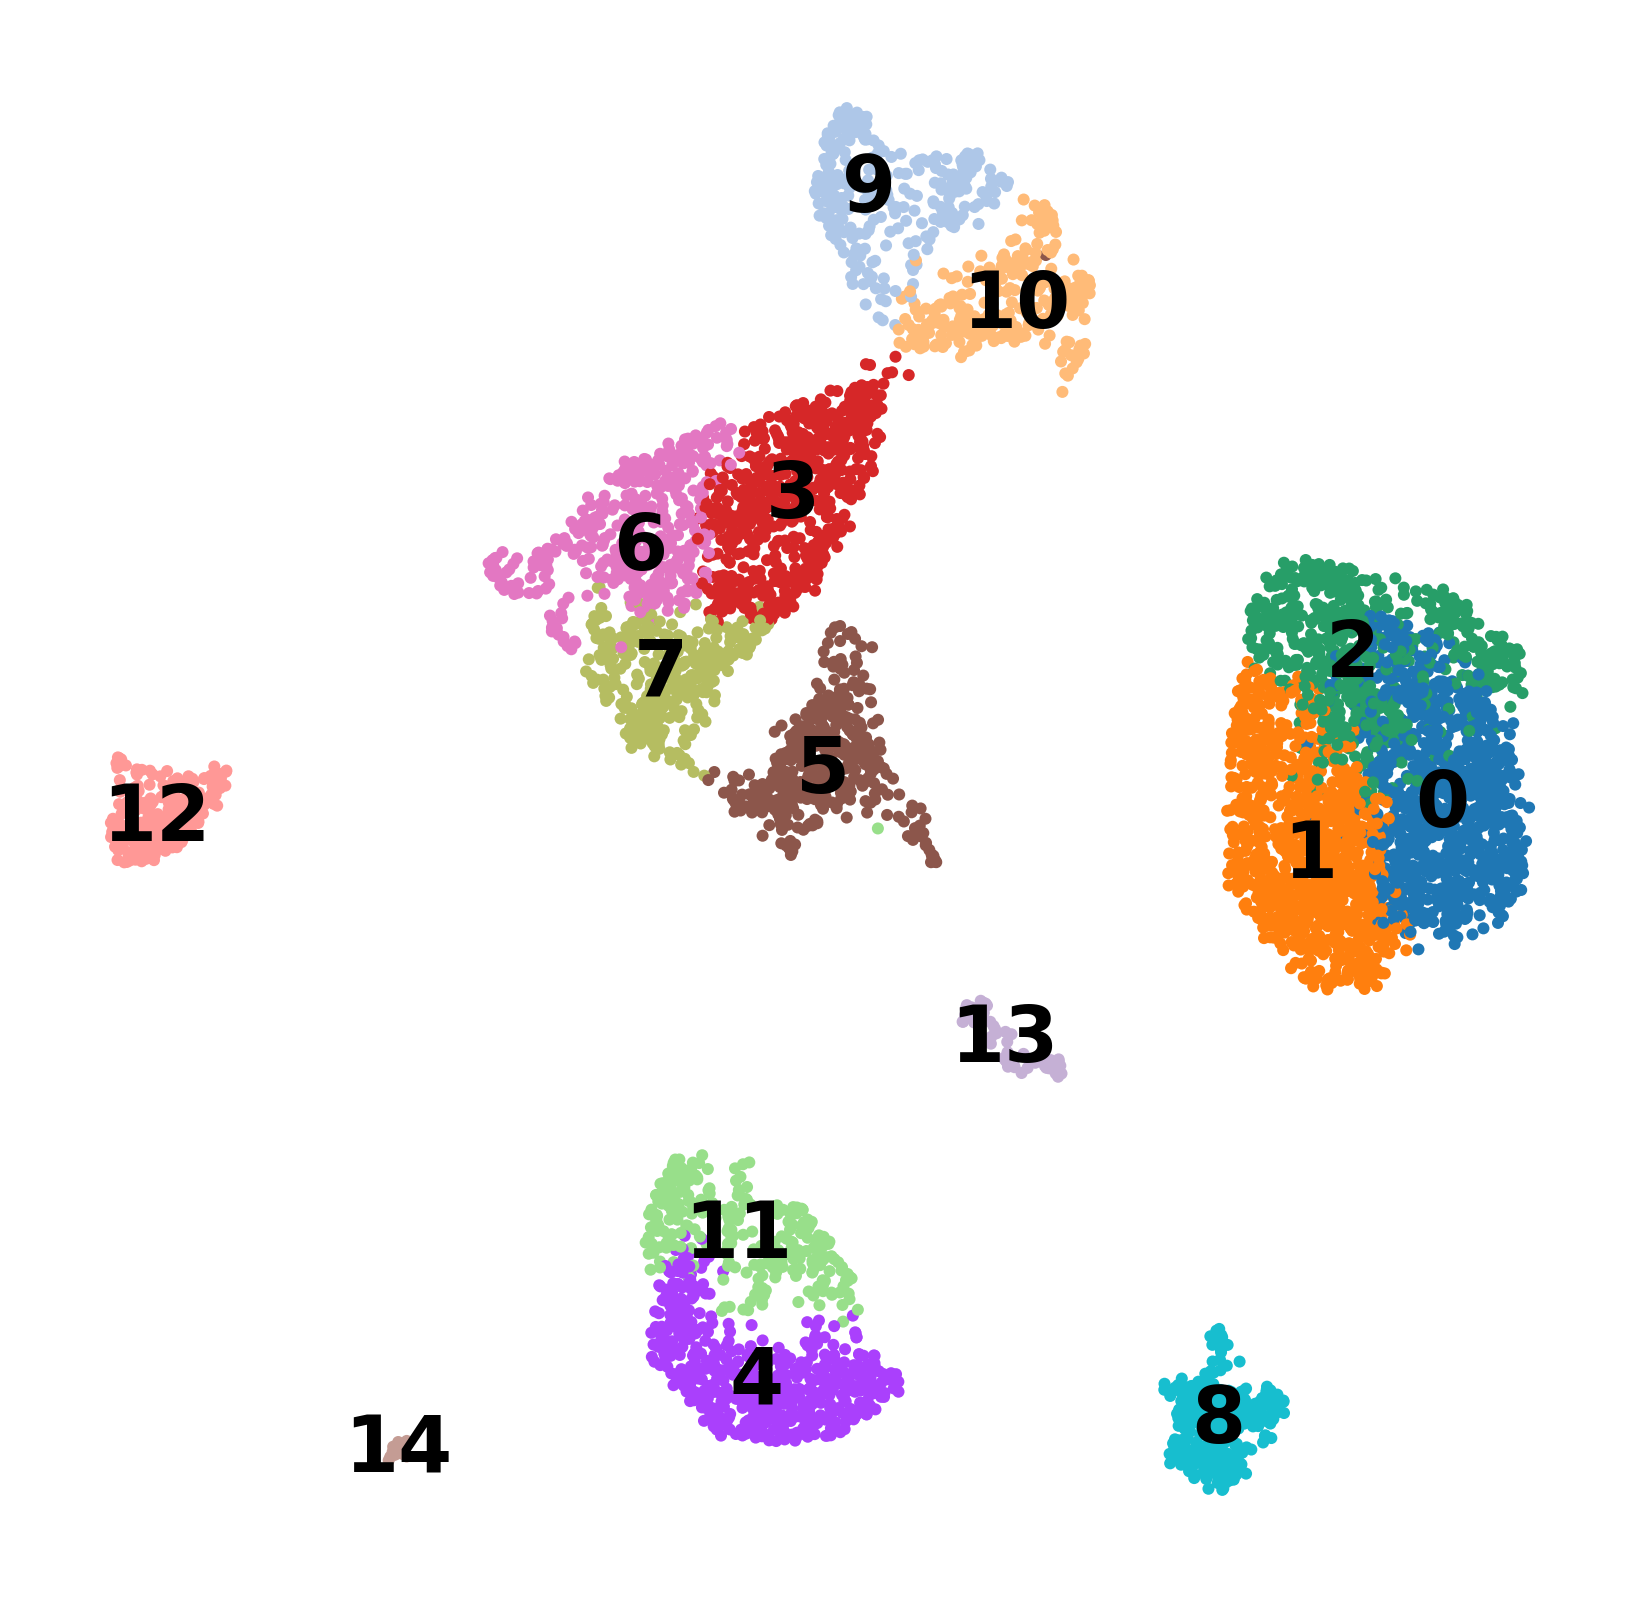

In [ ]:
sc.settings.set_figure_params(dpi=200, dpi_save=200, figsize=(5,5), facecolor='white')
sc.pl.umap(adata, color='leiden', legend_loc='on data', frameon=False, title='')

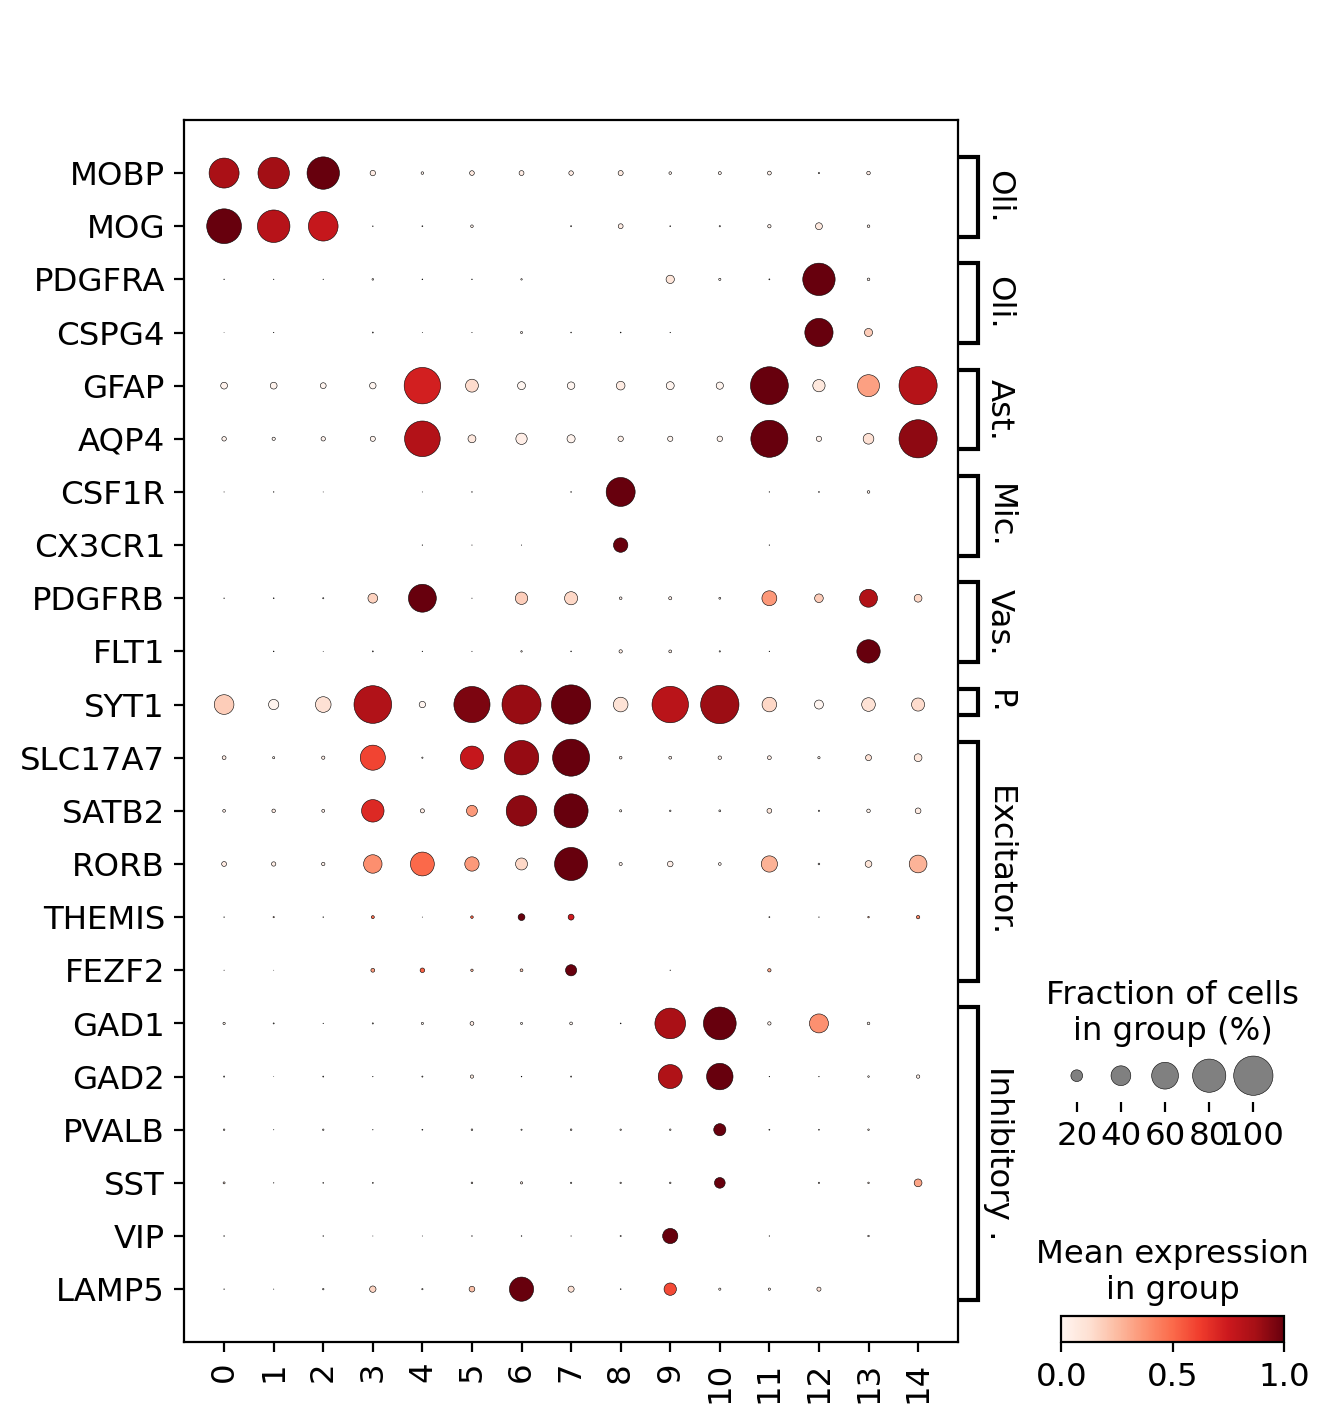

In [ ]:
marker_dict = {
    'Oligodendrocyte': ['MOBP', 'MOG'],
    'Oligodendrocyte Progenitor': ['PDGFRA', 'CSPG4'],
    'Astrocyte': ['GFAP', 'AQP4'],
    'Microglia': ['CSF1R', 'CX3CR1',],
    'Vasculature': ['PDGFRB', 'FLT1'],
    'Pan-neuronal': ['SYT1'],
    'Excitatory Neuron': ['SLC17A7', 'SATB2', 'RORB', 'THEMIS', 'FEZF2'],
    'Inhibitory Neuron': ['GAD1', 'GAD2', 'PVALB', 'SST', 'VIP', 'LAMP5']
}

sc.set_figure_params(dpi=100)
sc.pl.dotplot(
    adata, marker_dict, 'leiden', 
    standard_scale='var', swap_axes=True
)


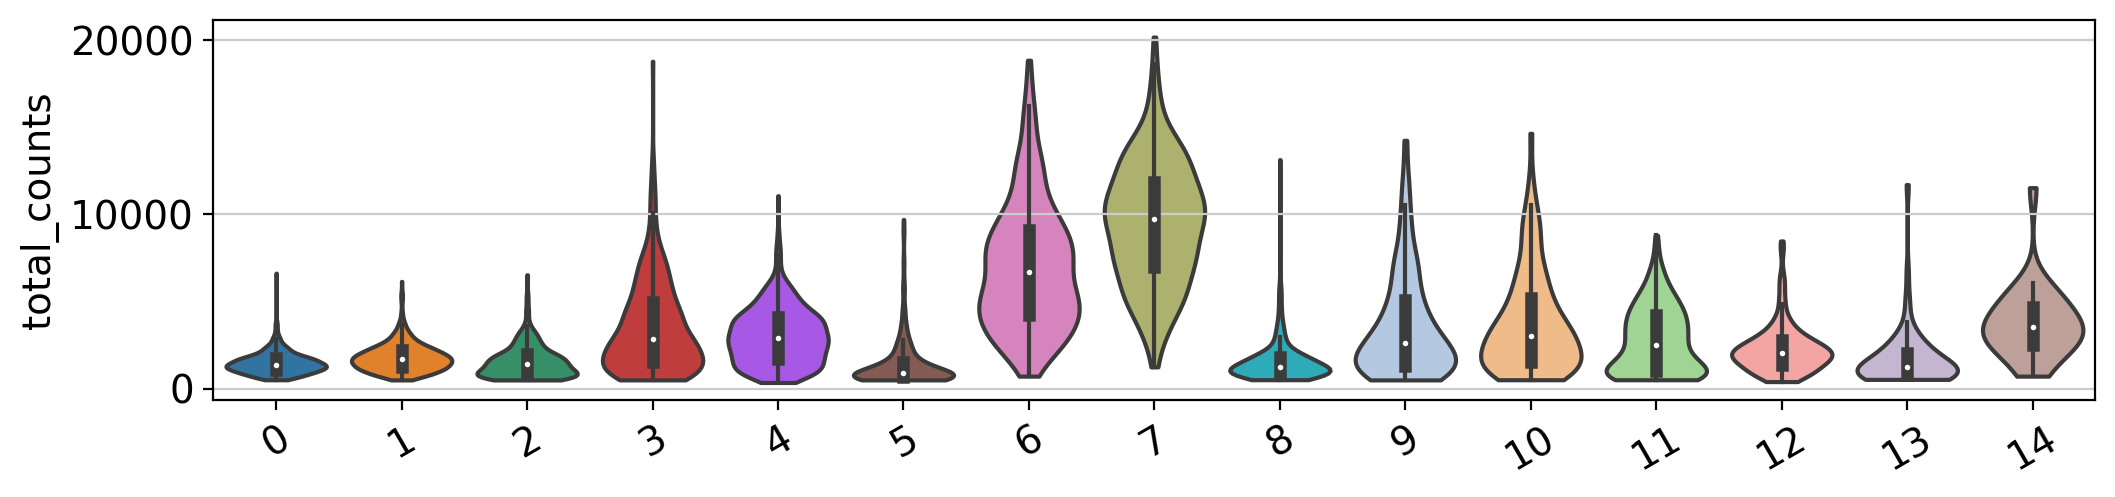

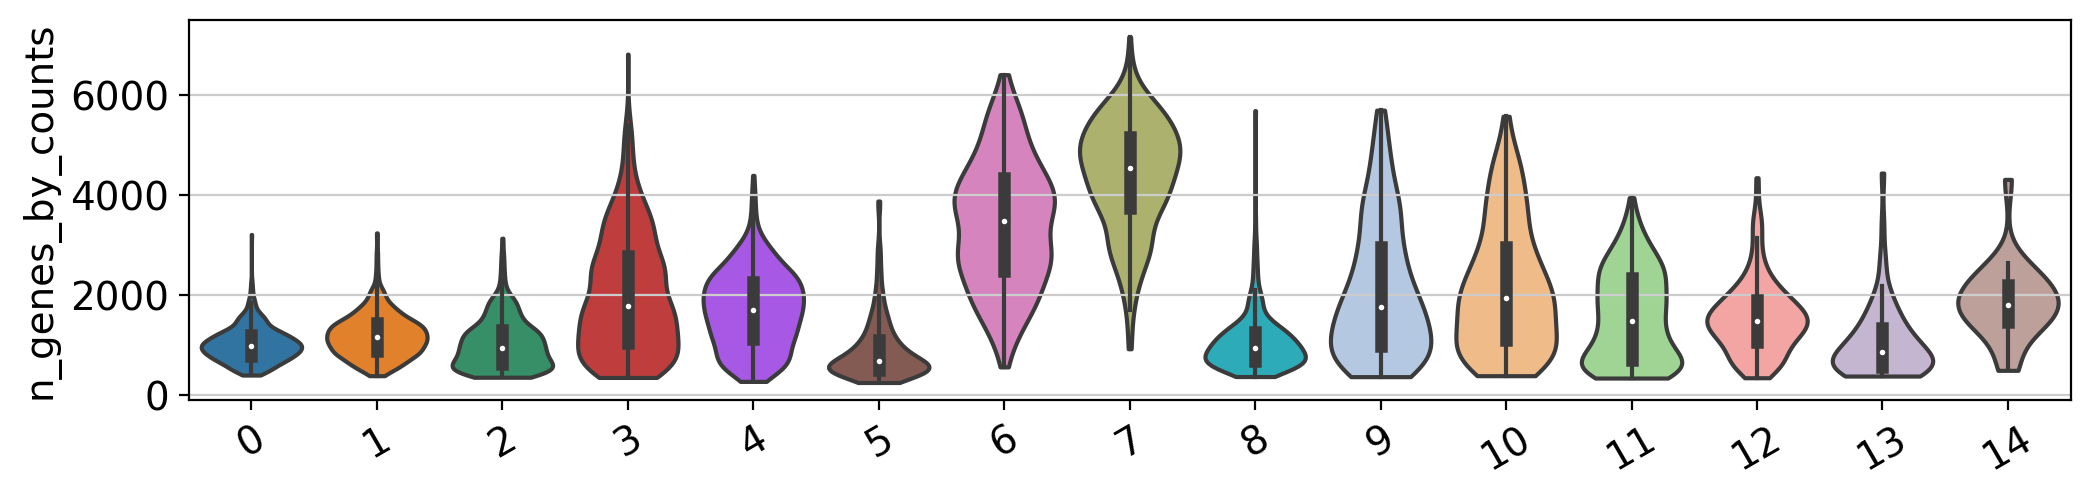

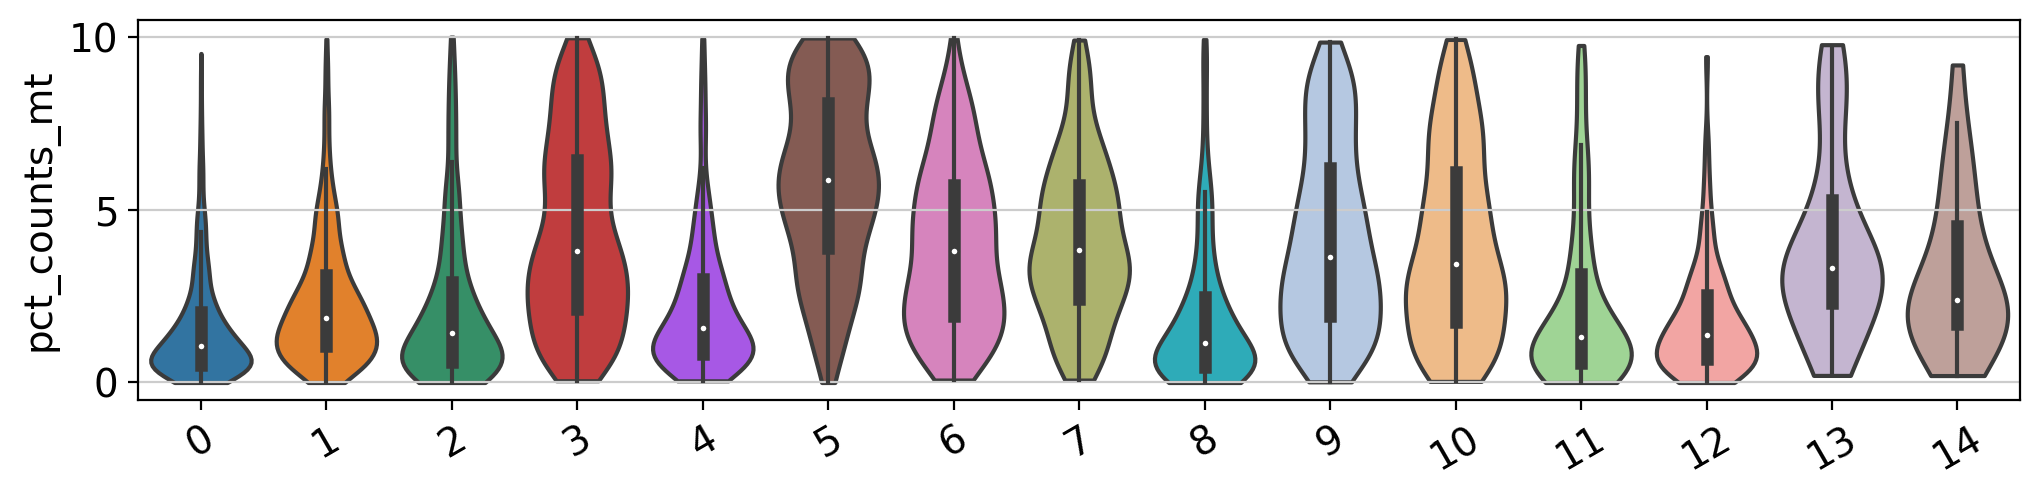

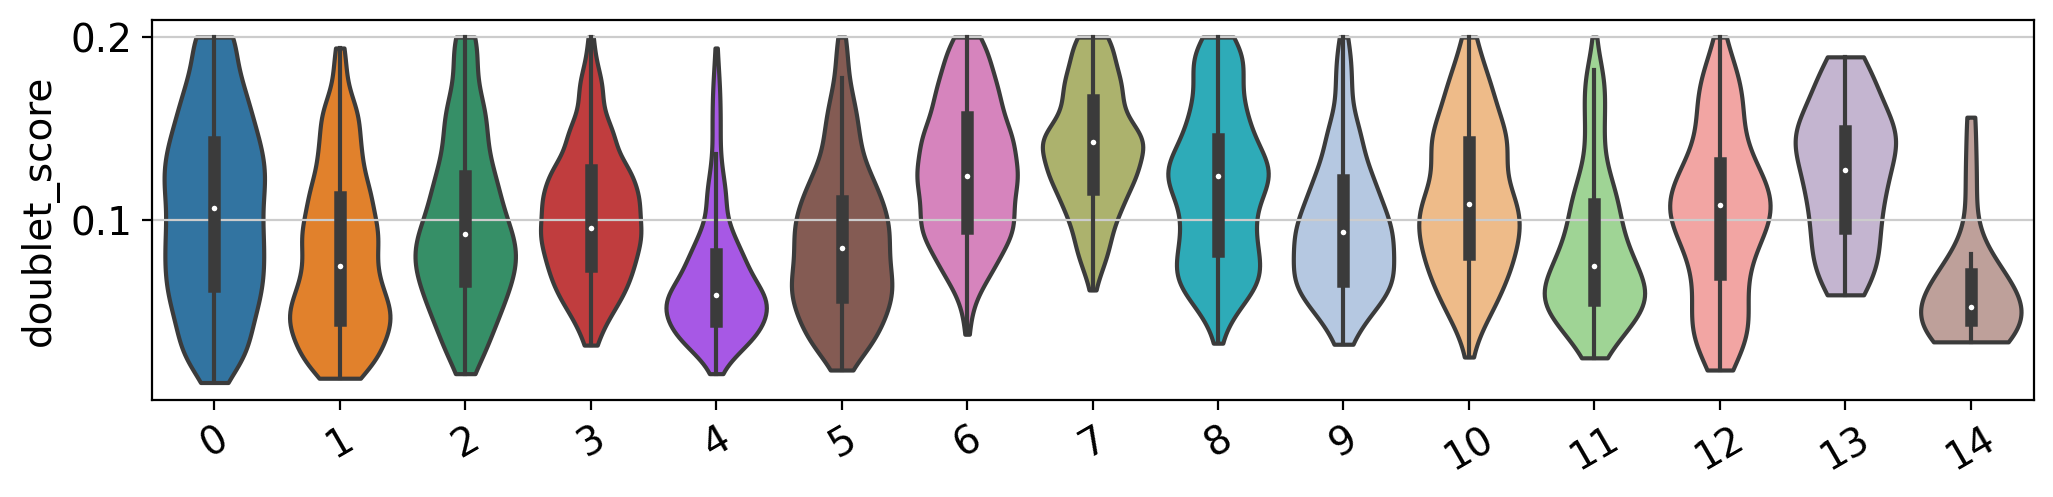

In [ ]:
sc.settings.set_figure_params(dpi=100, figsize=(10,2.5), facecolor='white')
sc.pl.violin(adata,[ 'total_counts'], inner='box', size=0,  groupby='leiden', multi_panel=False, rotation=30)
sc.pl.violin(adata,[ 'n_genes_by_counts'], inner='box', size=0,  groupby='leiden', multi_panel=False, rotation=30)
sc.pl.violin(adata,[ 'pct_counts_mt'], inner='box', size=0,  groupby='leiden', multi_panel=False, rotation=30)
sc.pl.violin(adata,[ 'doublet_score'], inner='box', size=0,  groupby='leiden', multi_panel=False, rotation=30)

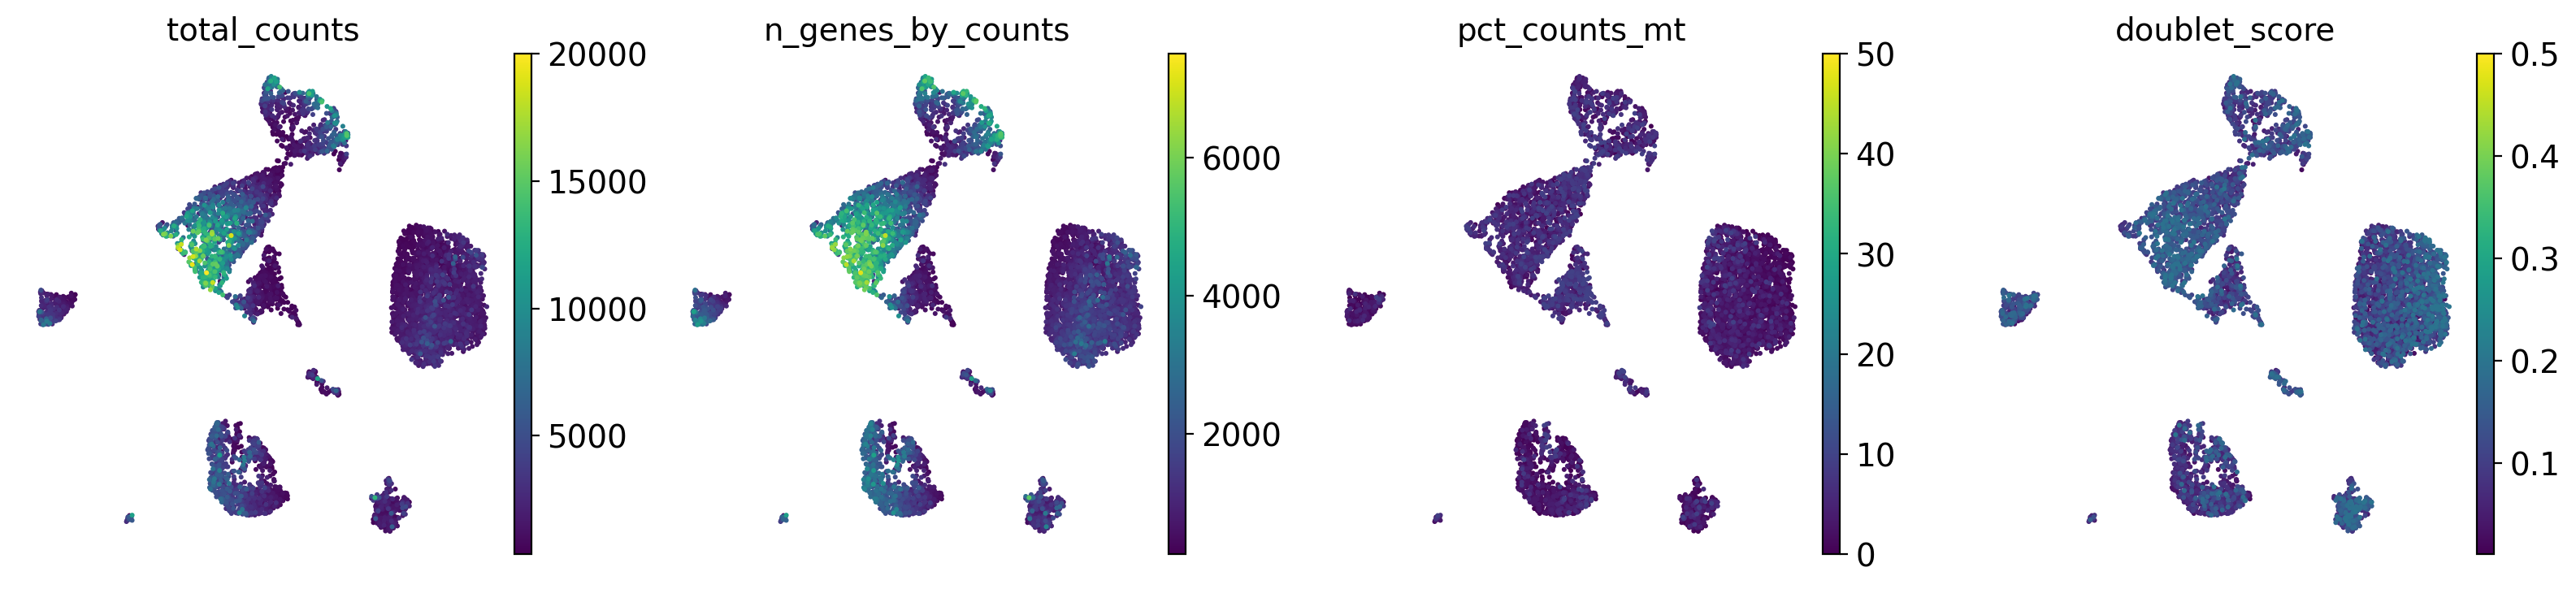

In [ ]:
sc.settings.set_figure_params(dpi=100, dpi_save=1000, figsize=(4,4), facecolor='white')
sc.pl.umap(adata, color=['total_counts', 'n_genes_by_counts', 'pct_counts_mt', 'doublet_score'], frameon=False, vmax=[20000, 7500, 50, 0.5])

## Try out other filtering strategies!! 

Go back to the blocks above to try changing the filtering thresholds. Remember to re-load from the adata object from after the doublet calling (below).

In [ ]:
# start with this adata object: 
adata = adata_doublet.copy()